<a href="https://colab.research.google.com/github/eth212/Qmind_MNIST_GAN/blob/main/Mnist_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author : Ethan Bonnardeaux**

---


**Date : December 2nd, 2020**


---


Sources Used : 
 - https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
 - https://www.youtube.com/watch?v=tX-6CMNnT64&ab_channel=AvivElbag



In [18]:
import cv2
from matplotlib import pyplot as plt
import numpy as np 
from keras.datasets import mnist

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

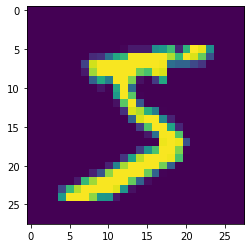

In [20]:
plt.imshow(x_train[0])

In [21]:
print(f"Training data has shape {str(x_train.shape)}") # 60,000 images for training with dimensions 28 pixels in width and 28 pixels in height
print(f"Validation Data has Shape {str(x_test.shape)}") # 10,000 images for testing with the same dimensions

Training data has shape (60000, 28, 28)
Validation Data has Shape (10000, 28, 28)


In [22]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test / 255.0

 - (One Hot Encoding) Converting the labels from 1D vector ranging [0,9] integers into 10-D vector where each x_i in (x_1,...x_10) is either 1 or 0
 - This lets me form a classification problem where there isn't a natural heirachy between each class


In [23]:
buffer = []
for i in range(len(y_train)):
  temp = [0] * 10
  temp[y_train[i]] = 1
  buffer.append(temp)
y_train = np.array(buffer)

buffer = []
for i in range(len(y_test)):
  temp = [0] * 10
  temp[y_test[i]] = 1
  buffer.append(np.array(temp))
y_test = np.array(buffer)

#Discriminator#

In [24]:
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, BatchNormalization, Flatten, Dropout, Conv2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

Experimental Training and Tuning


In [25]:
  lr = 0.001
  nst = False
  model_d = Sequential()
  model_d.add(Conv2D(10, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model_d.add(Dropout(0.25))
  model_d.add(MaxPool2D())
  model_d.add(Conv2D(15,(2,2), activation='relu'))
  model_d.add(Dropout(0.35))
  model_d.add(Flatten())
  # model_d.add(Dense(50, activation='relu'))
  model_d.add(Dense(10, activation='softmax'))
  sgd = SGD(learning_rate=lr, nesterov=nst) # consider using Nesterov Look ahead
  model_d.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])

In [26]:
model_d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 10)        100       
_________________________________________________________________
dropout_6 (Dropout)          (None, 26, 26, 10)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 10)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 15)        615       
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 15)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2160)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

Discriminator complexity is minimized by the number of trainable parameters and the training proves it's incremental increase in accuracy per epoch (without beginning at a very high value) which will allow the generator to learn simple patterns and incrementaly improve to understand the complex filters learned by discriminator 
- Note: it seems like random seeding plays a large part in the models accuracy for epoch #1 so I will consider setting the initial biases manually 

In [17]:
model_d.fit(x_train, y_train, shuffle=True, validation_data=(x_test, y_test), batch_size=40, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 1.4016 - acc: 0.5613 - val_loss: 0.6321 - val_acc: 0.8677
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5900 - acc: 0.8175 - val_loss: 0.4397 - val_acc: 0.8940
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5024 - acc: 0.8455 - val_loss: 0.3928 - val_acc: 0.9034
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4567 - acc: 0.8608 - val_loss: 0.3685 - val_acc: 0.9085
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4293 - acc: 0.8706 - val_loss: 0.3538 - val_acc: 0.9113


In [58]:
def make_discriminator(lr=0.01, nst=False):
  model = Sequential()
  model.add(Conv2D(10, (3,3), activation='relu', input_shape=x_train.shape[1:]))
  model.add(Dropout(0.25))
  model.add(MaxPool2D())
  model.add(Conv2D(15,(2,2), activation='relu'))
  model.add(Dropout(0.35))
  model.add(Flatten())
  # model_d.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  sgd = SGD(learning_rate=lr, nesterov=nst) # consider using Nesterov Look ahead
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc'])
  return model

#Defining the Generator #
**Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
**Outputs**: Two-dimensional square grayscale image of 28×28 pixels with pixel values in [0,1].
**Notes**: 
 - 100 element latent space is subject to change however is the widely used noise vector size

In [28]:
def make_generator(latent_dimension, num_parellel_images=128):
  # transform latent_dimension into 28x28 pixel image
  model = Sequential()
  # start with low res generated image (RxR) and Define R as 7 so that we can double its size twice and achieve 28x28
  low_res_dim = 7
  init_permutations = num_parellel_images # number of parelled interpretations of low res image
  model.add(Dense(init_permutations * (low_res_dim ** 2), input_dim=latent_dimension, activation='relu')) # maybe change to input_shape
  model.add(Reshape((low_res_dim, low_res_dim, init_permutations)))
  # de-convolution process (Either UpSampling2D then Conv2D or Conv2DTranspose)
  model.add(Conv2DTranspose(init_permutations, (4,4), strides=(2,2), padding='same', activation='relu')) # (4,4) kernel size which is a factor of the strides (2,2) -> avoid checkerboard pattern 
  # the stride size increase generated shape from (R*s1, R*s1)
  # now the generated images will be (14, 14)
  model.add(Conv2DTranspose(init_permutations, (4,4), strides=(2,2), padding='same', activation='relu'))
  # now upsampled images are size (28, 28)
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same')) # sigmoid used to ensure values are in [0,1]
  return model



Re-Visit and attempt to decrease number of trainable-params

In [42]:
LATENT_DIM = 100
model_d = make_discriminator(lr=0.001) # decrease learning rate to slow training process
model_g = make_generator(LATENT_DIM, num_parellel_images=80) # start with low number of parellel images
model_g.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 3920)              395920    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 80)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 80)        102480    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 80)        102480    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 1)         3921      
Total params: 604,801
Trainable params: 604,801
Non-trainable params: 0
_________________________________________________________________


In [30]:
def randomize_latent_points(dim, amount):
  x = np.random.randn(dim * amount)
  x = x.reshape(amount, dim)
  return x

In [46]:
def generate_samples(generator, latent_dim, amount):
  x = randomize_latent_points(latent_dim, amount)
  generated_samples = generator.predict(x)
  fake_labels = []
  for i in range(amount):
    temp = [0] * 10
    temp[(np.random.randint(0,9))] = 1
    fake_labels.append(np.array(temp))
  return generated_samples, np.array(fake_labels)

Displaying generated samples which are random with an untrained generator model

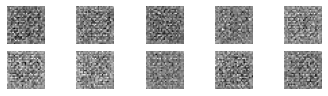

In [54]:
X, Y = generate_samples(model_g, LATENT_DIM, 10)
for i in range(10):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
plt.show()

GAN will be trained without updating the discriminator, only the generator's weights will be improved until the discriminator is updated seperately

In [55]:
def make_gan(model_g, model_d, lr=0.001):
  model_d.trainable = False
  gan = Sequential()
  gan.add(model_g)
  gan.add(model_d)
  optimizer = SGD(lr=lr)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer)
  return model

In [56]:
def training_step(gan, latent_dim, epochs=50, n_batch=256):
  for i in range(epochs):
    z = randomize_latent_points(latent_dim, batch_size)
    # inverted labels
    generator_labels = []
    for i in range(n_batch):
      temp = [1] * 10
      generator_labels.append(np.array(temp))
    generator_labels = np.array(generator_labels)
    gan.train_on_batch(z, generator_labels)

In [ ]:
def train(model_g, model_d, gan, x_real, latent_dim, epochs, n_batch):
  

In [57]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>79, 152/234, d=0.691, g=0.703
>79, 153/234, d=0.691, g=0.684
>79, 154/234, d=0.691, g=0.697
>79, 155/234, d=0.691, g=0.683
>79, 156/234, d=0.699, g=0.687
>79, 157/234, d=0.675, g=0.697
>79, 158/234, d=0.693, g=0.699
>79, 159/234, d=0.690, g=0.702
>79, 160/234, d=0.690, g=0.718
>79, 161/234, d=0.690, g=0.717
>79, 162/234, d=0.689, g=0.720
>79, 163/234, d=0.689, g=0.701
>79, 164/234, d=0.695, g=0.703
>79, 165/234, d=0.687, g=0.693
>79, 166/234, d=0.690, g=0.700
>79, 167/234, d=0.690, g=0.714
>79, 168/234, d=0.686, g=0.701
>79, 169/234, d=0.685, g=0.685
>79, 170/234, d=0.691, g=0.705
>79, 171/234, d=0.692, g=0.708
>79, 172/234, d=0.695, g=0.703
>79, 173/234, d=0.684, g=0.690
>79, 174/234, d=0.692, g=0.691
>79, 175/234, d=0.693, g=0.705
>79, 176/234, d=0.689, g=0.710
>79, 177/234, d=0.693, g=0.701
>79, 178/234, d=0.699, g=0.697
>79, 179/234, d=0.691, g=0.689
>79, 180/234, d=0.687, g=0.692
>79, 181/234, d=0.690, g=0.706
>79, 182/234, d=0.6